In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import os
import pandas as pd
import torch
from dataset_preprocessing import TokenInfo
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import itertools
import pandas as pd
from tqdm import tqdm

## Importances

In [4]:
def get_importances():
    # print("this is wrong")
    dir = "./new_importances_data"
    imp_files = os.listdir(dir)
    imp_files = [file for file in imp_files if file.endswith(".pkl")]
    importances = {}
    for imp_file in tqdm(imp_files):
        importances.update(pd.read_pickle(f"{dir}/{imp_file}"))
    return importances

In [5]:
# imps = get_importances()

In [6]:
def get_avg_imporances(importances):
    avg_imps = [torch.zeros_like(imp) for imp in list(importances.values())[0]]
    for token, imps in tqdm(importances.items()):
        for i, layer_imps in enumerate(imps):
            avg_imps[i] += layer_imps / len(importances)
    # TODO think harder about averaging method
    return avg_imps

In [7]:
# avg_importances = get_avg_imporances(imps)

In [8]:
# pd.to_pickle(avg_importances, "./avg_importances.pkl")

In [9]:
avg_importances = pd.read_pickle("./avg_importances.pkl")

In [10]:
len(avg_importances)

24

## Model

In [11]:
model_id = "microsoft/phi-1_5"
model_revision = "349cf8b5e81fd5f791d1740da5de1313a0419bbd" # latest as of feb 1st

In [12]:
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

In [13]:
vocab = tokenizer.get_vocab()
len(vocab)

50295

In [14]:
# tokenizer.decode(token_info.get_prefixes(top_tokens[1000][0], 9, 10)[0])

In [15]:
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    revision=model_revision,
    trust_remote_code=True,
    # be careful with this?
    # torch_dtype=torch.float16,
    # attn_implementation="flash_attention_2",
)

## Prune Model

In [16]:
from prunners import prune_mlps_individually
from importances import get_mlps

In [17]:
mlps = get_mlps(model)

In [18]:
len(mlps), len(avg_importances)

(24, 24)

In [19]:
avg_importances = dict(zip(mlps, avg_importances))

In [20]:
prune_mlps_individually(avg_importances, 0.5)

In [21]:
model

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2048)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-23): 24 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (dense): Linear(in_features=2048, out_features=2048, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2048, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=2048, bias=True)
        )
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (final_layernorm): LayerNorm((2048,), e

## New Dataset

In [22]:
from other_datasets import get_minipile, get_c4, get_wikitext2_filtered, get_bookcorpus, get_alpaca, QADataCollator, to_dataset
from dataset import get_baseline_dataset

/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


In [23]:
alpaca_train, alpaca_eval = get_alpaca(tokenizer, do_split=True)
# eval datasets
# tiny_text = get_baseline_dataset()["test"]
# c4 = get_c4(n=2000, do_split=False)
# minipile = get_minipile(n=2000, do_split=False)
wikitext = get_wikitext2_filtered(n=2000, do_split=False)
# bookcorpus = get_bookcorpus(n=2000, do_split=False)

2024-03-06 14:18:21.998 | INFO     | other_datasets:__init__:309 - Mean length of tokens per window: 111.64232
2024-03-06 14:18:22.648 | INFO     | other_datasets:__init__:309 - Mean length of tokens per window: 109.2675


## Metric Callback

In [24]:
from transformers import TrainerCallback

In [25]:
from evaluation import evaluate_on_nlp_tasks

In [26]:
class AccEvalCallback(TrainerCallback):
    def __init__(self):
        super().__init__()
        self.last_step=-1
    
    def on_evaluate(self, args, state, control, model, **kwargs):
        if state.global_step == self.last_step:
            return
        self.last_step = state.global_step
        train = model.training
        model.eval()
        with torch.no_grad():
            os.environ["TQDM_DISABLE"] = "1"
            eval_res = evaluate_on_nlp_tasks(model, tokenizer, limit=1000)["results"]
            # import pdb; pdb.set_trace()
            eval_res = {k:v["acc,none"] for k,v in eval_res.items()}
            for k, v in eval_res.items():
                state.log_history.append(
                    {
                        k:v,
                        "epoch":state.epoch,
                        "step":state.global_step,
                    }
                )
            del os.environ['TQDM_DISABLE']
            print(eval_res)
        model.train(train)

In [27]:
class EnableMLPBias(TrainerCallback):
    def on_init_end(self, args, state, control, model, **kwargs):
        for n, p in model.named_parameters():
            if "base_layer" in n and "bias" in n:
                p.requires_grad = True

## Train model

In [28]:
from peft import LoraConfig, PeftConfig
import transformers

In [29]:
from post_training import get_lora_config, get_training_arguments
from other_datasets import SFTTrainer_
from trl import SFTTrainer

In [30]:
lora_config = get_lora_config(r=64)
training_arguments = get_training_arguments("./tmp")

In [31]:
model.cuda();

In [32]:
model.config.use_cache = False
model.config.pretraining_tp = 1
model.gradient_checkpointing_enable()

In [33]:
# train_data, eval_data = minipile["train"], minipile["test"]
train_data, eval_data = alpaca_train, alpaca_eval
eval_datasets = {
    "alpaca":alpaca_eval,
    # "minipile":minipile,
    # "c4":c4,
    "wikitext":wikitext,
    # "tiny_text":tiny_text,
    # "bookcorpus":bookcorpus,
}

In [34]:
callbacks = [AccEvalCallback(), EnableMLPBias()]

In [35]:
tokenizer.pad_token = tokenizer.eos_token

In [36]:
training_arguments.save_strategy="no"

In [37]:
training_arguments.eval_steps = 100

In [38]:
trainer = SFTTrainer_(
    model=model,
    train_dataset=train_data,
    eval_dataset=eval_datasets,
    # eval_dataset={k:v.select(range(0, 100)) for k, v in eval_datasets.items()},
    # eval_dataset=eval_datasets["minipile"],
    peft_config=lora_config,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=False,
    dataset_text_field="text",
    max_seq_length=1024, # tweak this
    # TODO: think harder about the datacollator
    # data_collator=transformers.DataCollatorForSeq2Seq(
    #     tokenizer, pad_to_multiple_of=8, return_tensors="pt", padding=True
    # ),
    callbacks=callbacks,
    data_collator=QADataCollator(tokenizer),
)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

2024-03-06:14:18:42,484 WARNING  [logging.py:61] Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [39]:
model.model.layers[0].mlp.fc1.base_layer.weight

Parameter containing:
tensor([[-0.0109,  0.0299,  0.0062,  ...,  0.0533, -0.0579,  0.0222],
        [-0.0191,  0.0190, -0.0047,  ...,  0.0625, -0.0063, -0.0221],
        [-0.0254, -0.0176, -0.0102,  ...,  0.0064,  0.0209,  0.0180],
        ...,
        [ 0.0443, -0.0440,  0.0129,  ...,  0.0148,  0.0323,  0.0180],
        [-0.0003, -0.0041, -0.0067,  ..., -0.0082, -0.0086,  0.0221],
        [-0.0157, -0.0372, -0.0213,  ..., -0.0288, -0.0250, -0.0317]],
       device='cuda:0')

In [40]:
model.model.layers[0].mlp.fc1.base_layer.bias

Parameter containing:
tensor([-0.0210, -0.0126, -0.0157,  ..., -0.0200, -0.0035, -0.0140],
       device='cuda:0', requires_grad=True)

In [ ]:
# model.eval();
# with torch.no_grad():
#     eval_res = evaluate_on_nlp_tasks(model, tokenizer, limit=1000)
# model.train()

In [85]:
eval_res["results"]

{'hellaswag': {'acc,none': 0.348,
  'acc_norm,none': 0.443,
  'alias': 'hellaswag'},
 'piqa': {'acc,none': 0.671, 'acc_norm,none': 0.665, 'alias': 'piqa'},
 'boolq': {'acc,none': 0.625, 'alias': 'boolq'},
 'winogrande': {'acc,none': 0.522, 'alias': 'winogrande'}}

In [41]:
train_res = trainer.train()

Step,Training Loss,Validation Loss,Alpaca Loss,Wikitext Loss
100,2.051200,No log,2.049421,4.595955
200,1.854500,No log,1.858034,4.429690
300,1.765400,No log,1.810117,4.389284
400,1.734000,No log,1.784144,4.364333
500,1.779700,No log,1.768275,4.337015
600,1.736800,No log,1.759247,4.317789
700,1.779000,No log,1.750195,4.309574
800,1.709600,No log,1.743682,4.311879
900,1.729100,No log,1.739597,4.301714
1000,1.721300,No log,1.736435,4.294729


2024-03-05:13:34:53,792 WARNING  [huggingface.py:105] `pretrained` model kwarg is not of type `str`. Many other model arguments may be ignored. Please do not launch via accelerate or use `parallelize=True` if passing an existing model this way.
2024-03-05:13:34:53,820 WARNING  [huggingface.py:315] Passed an already-initialized model through `pretrained`, assuming single-process call to evaluate() or custom distributed integration
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
 61%|███████████████▊          | 6059/10000 [06:56<05

{'hellaswag': 0.391, 'piqa': 0.722, 'boolq': 0.631, 'winogrande': 0.594}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████| 10000/10000 [08:01<00:00, 20.76it/s]


{'hellaswag': 0.392, 'piqa': 0.716, 'boolq': 0.636, 'winogrande': 0.591}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████| 10000/10000 [08:55<00:00, 18.66it/s]


{'hellaswag': 0.394, 'piqa': 0.71, 'boolq': 0.635, 'winogrande': 0.586}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████| 10000/10000 [11:16<00:00, 14.79it/s]


{'hellaswag': 0.39, 'piqa': 0.712, 'boolq': 0.63, 'winogrande': 0.595}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████| 10000/10000 [10:45<00:00, 15.50it/s]


{'hellaswag': 0.39, 'piqa': 0.713, 'boolq': 0.632, 'winogrande': 0.597}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████| 10000/10000 [11:00<00:00, 15.14it/s]


{'hellaswag': 0.39, 'piqa': 0.718, 'boolq': 0.632, 'winogrande': 0.596}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████| 10000/10000 [11:16<00:00, 14.77it/s]


{'hellaswag': 0.389, 'piqa': 0.715, 'boolq': 0.631, 'winogrande': 0.591}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████| 10000/10000 [10:32<00:00, 15.82it/s]


{'hellaswag': 0.39, 'piqa': 0.719, 'boolq': 0.631, 'winogrande': 0.596}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████| 10000/10000 [11:09<00:00, 14.94it/s]


{'hellaswag': 0.392, 'piqa': 0.714, 'boolq': 0.632, 'winogrande': 0.591}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████| 10000/10000 [11:12<00:00, 14.86it/s]


{'hellaswag': 0.392, 'piqa': 0.713, 'boolq': 0.632, 'winogrande': 0.587}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█████████████████████████| 10000/10000 [10:43<00:00, 15.53it/s]


{'hellaswag': 0.393, 'piqa': 0.714, 'boolq': 0.634, 'winogrande': 0.588}


fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [42]:
pd.to_pickle(trainer.state, "./tmp/alpaca_trainer_state_llm_pruner_style_0.5ratio_64lora.pkl")

In [43]:
trainer_state = trainer.state
pd.DataFrame(trainer_state.log_history).tail()

,loss,learning_rate,epoch,step,eval_alpaca_loss,eval_alpaca_runtime,eval_alpaca_samples_per_second,eval_alpaca_steps_per_second,hellaswag,piqa,...,winogrande,eval_wikitext_loss,eval_wikitext_runtime,eval_wikitext_samples_per_second,eval_wikitext_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
259,1.6977,2.298851e-06,1.96,1630,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
260,1.6833,1.660281e-06,1.97,1640,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261,1.6916,1.021711e-06,1.98,1650,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
262,1.6954,3.831418e-07,1.99,1660,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263,NaN,NaN,2.00,1666,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,18609.8924,5.373,0.09,1.067754e+17,1.78843


### Evaluation

In [44]:
from evaluation import evaluate_on_nlp_tasks

In [45]:
model.eval();

In [46]:
with torch.no_grad():
    eval_res = evaluate_on_nlp_tasks(model, tokenizer, limit=300)

/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|███████████████████████████| 3000/3000 [02:34<00:00, 19.42it/s]
fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [47]:
eval_res["results"]

{'hellaswag': {'acc,none': 0.39666666666666667,
  'acc_norm,none': 0.45,
  'alias': 'hellaswag'},
 'piqa': {'acc,none': 0.7066666666666667,
  'acc_norm,none': 0.72,
  'alias': 'piqa'},
 'boolq': {'acc,none': 0.6366666666666667, 'alias': 'boolq'},
 'winogrande': {'acc,none': 0.6066666666666667, 'alias': 'winogrande'}}

In [73]:
eval_res = evaluate_on_nlp_tasks(model, tokenizer, limit=1000, bootstrap_iters=1000)

/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█| 10000/10000 [08:50<00:00, 18.85it
fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [74]:
eval_res["results"]

{'hellaswag': {'acc,none': 0.394,
  'acc_stderr,none': 0.015459721957493382,
  'acc_norm,none': 0.483,
  'acc_norm_stderr,none': 0.015810153729833434,
  'alias': 'hellaswag'},
 'piqa': {'acc,none': 0.717,
  'acc_stderr,none': 0.01425181090648175,
  'acc_norm,none': 0.71,
  'acc_norm_stderr,none': 0.014356395999905689,
  'alias': 'piqa'},
 'boolq': {'acc,none': 0.635,
  'acc_stderr,none': 0.015231776226264902,
  'alias': 'boolq'},
 'winogrande': {'acc,none': 0.59,
  'acc_stderr,none': 0.015560917136921669,
  'alias': 'winogrande'}}

In [70]:
x = evaluate_on_nlp_tasks(model, tokenizer, limit=100, bootstrap_iters=1000)

/home/research/robgarct/.conda/envs/cs224n-pip3/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
100%|█| 1000/1000 [00:54<00:00, 18.25it/s
fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [72]:
x["results"]

{'hellaswag': {'acc,none': 0.43,
  'acc_stderr,none': 0.049756985195624284,
  'acc_norm,none': 0.48,
  'acc_norm_stderr,none': 0.050211673156867795,
  'alias': 'hellaswag'},
 'piqa': {'acc,none': 0.73,
  'acc_stderr,none': 0.044619604333847394,
  'acc_norm,none': 0.74,
  'acc_norm_stderr,none': 0.04408440022768079,
  'alias': 'piqa'},
 'boolq': {'acc,none': 0.72,
  'acc_stderr,none': 0.04512608598542127,
  'alias': 'boolq'},
 'winogrande': {'acc,none': 0.65,
  'acc_stderr,none': 0.0479372485441102,
  'alias': 'winogrande'}}

## Save

In [50]:
model.cpu();

In [51]:
torch.save(model.state_dict(), "./tmp/alpaca_model_llm_prunner_style_0.5ratio_64lora_state_dict")

## Looking at stats

In [52]:
df = pd.DataFrame(trainer_state.log_history)

In [53]:
metrics_df = df[["step", "hellaswag", "piqa", "boolq", "winogrande"]]

<Axes: xlabel='step'>

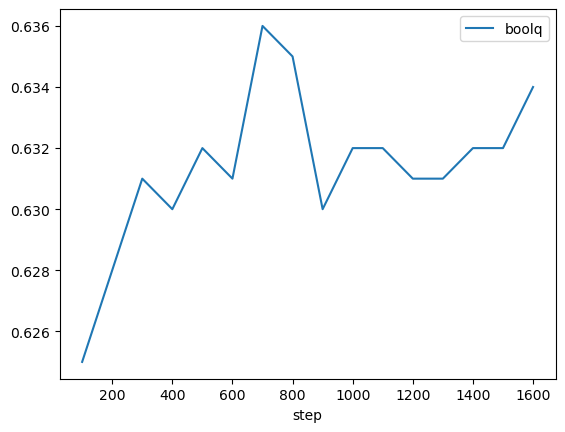

In [54]:
metrics_df[["step", "boolq"]].dropna().set_index("step").plot()

<Axes: xlabel='step'>

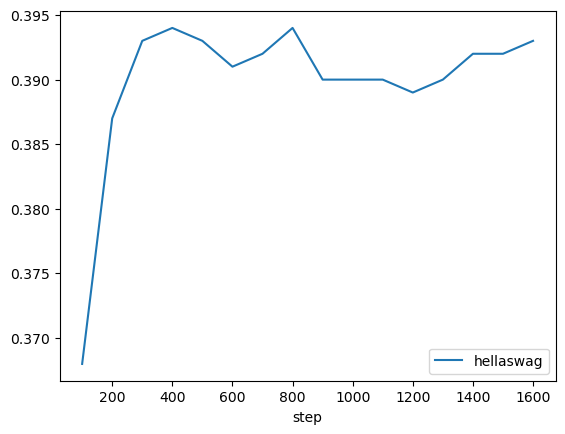

In [55]:
metrics_df[["step", "hellaswag"]].dropna().set_index("step").plot()

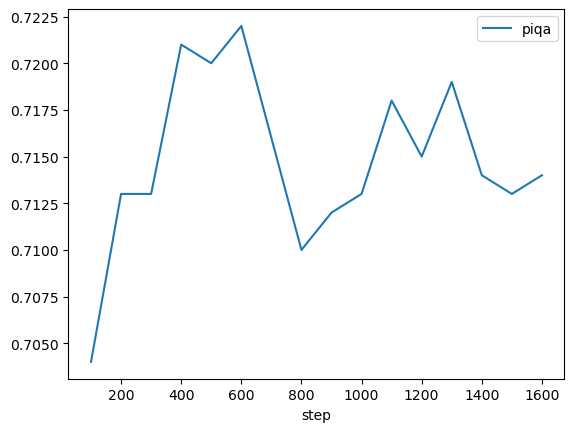

In [56]:
metrics_df = df[["step", "piqa"]].dropna().set_index("step").plot()

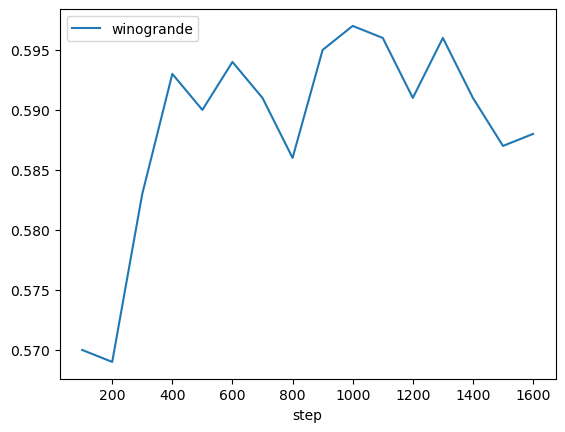

In [57]:
metrics_df = df[["step", "winogrande"]].dropna().set_index("step").plot()

In [59]:
eval_df = df[["step", "eval_alpaca_loss", "eval_wikitext_loss"]].set_index("step")

<Axes: xlabel='step'>

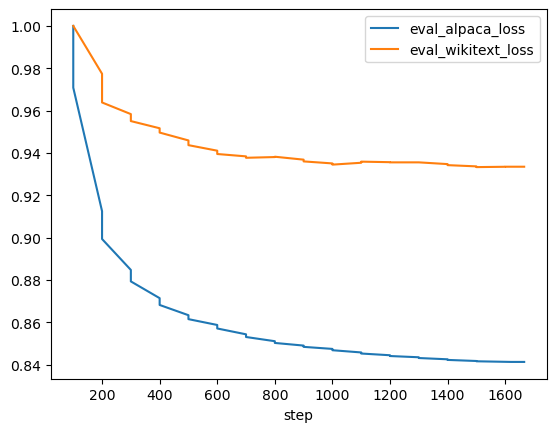

In [61]:
(eval_df / eval_df.max()).interpolate(method='linear').plot()

<Axes: xlabel='step'>

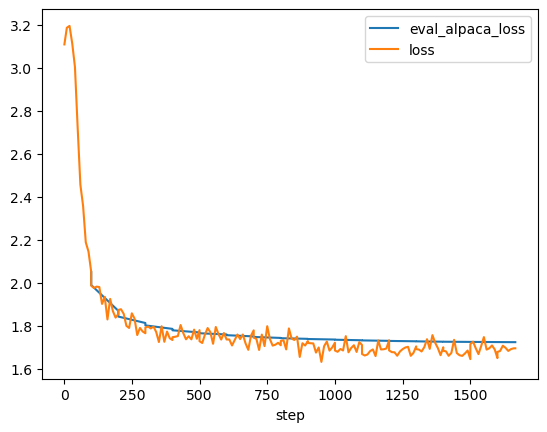

In [62]:
df[["step", "eval_alpaca_loss", "loss"]].set_index("step").interpolate(method='linear').plot()